# SEIRHVD Data Fit

This Jupyter notebooks implements the SEIRHVD model for fitting the actual Chilean data in order to make projections in VMI and bed usage, amount of infected and deaths. This model uses the SEIRHVD 4.1 version. A visual representation of the model is available at: [SEIRHVD Miró Model](https://miro.com/app/board/o9J_ktzN4xA=/)

This implements a single instance to facilitate understanding the model prior to run multiple data fittings at a time.



In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from datetime import datetime
from numpy import linalg as LA
import multiprocessing
from joblib import Parallel, delayed
from datetime import timedelta

import platform
OS = platform.system()

import matplotlib.pyplot as plt
if OS == 'Linux':    
    %matplotlib tk
    print('Linux')
elif OS == 'Windows':
    %matplotlib qt
    print('Windows')
elif OS == 'Darwin':
    %matplotlib tk
    print('Mac (Funciona?)')
else:
    print('OS not detected :-|')

import sys
from pathlib import Path
sys.path.insert(1, '../src/SEIRHVD/')
sys.path.insert(1, '../src/utils/')
sys.path.insert(1, 'src/SEIRHVD/')
sys.path.insert(1, 'src/utils/')

from class_SEIRHUVD5 import SEIRHVD 
from Quarantine import Quarantine
from Quarantine import SeroPrevDynamics
from importdata import ImportData

Linux


## Time Variables
Declare Initial date for simulating and data fitting

In [26]:
# First simulation Initial date
initdate = datetime(2020,12,1)
# Date for change in SeroPrevalence
SPchange_date = datetime(2020,7,25)

# Current date
currentdate = datetime.now()
currentday = (currentdate - initdate).days

fiestaspatrias = datetime(2020,9,18)
fiestaspatrias_day = (fiestaspatrias-initdate).days
plebiscito = datetime(2020,10,25)
plebiscito_day = (plebiscito-initdate).days

## Import Data
To import data we use an ImportData object which is initialized with the region's cut and the initial date. state region is represented by cut = 14.

In [27]:
print('Importing data from Region de Los Rios')
tstate = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16']
#tstate = '13101'
# Import Data
state = ImportData(tstate=tstate,initdate = initdate)
state.importdata()

Importing data from Region de Los Rios
Importing General Data
Importing Population
Importing Active infected
Importing Accumulated Infected
Importing Daily Infected
Importing ICU Beds Data
Importing Deaths by DEIS
Importing Active Infected by Minciencia
Done


In [28]:
state.name = 'Chile'
state.population

19458310

## Datos de Hospitalizados a fitear

In [29]:
state.Hr = 1000
state.Hr_tot = [10000,10000]
state.Vr = state.UCI_use_covid
state.Vr_tot = state.UCI_capacity
state.sochimi_tr = state.UCI_tr[-2:]
state.sochimi_dates = state.UCI_dates

## Simulation Parameters

In [30]:
# Total simulation time
tsim = 1000
t_sp = (SPchange_date - initdate).days

beta = 0.023
mu = 0.298
k_I = 0
k_R = 0#10
SeroPrevFactor = 1
expinfection=0 # Proportion in which the exposed infect - 0: nothing, 1: equally as Infected

## Quarantines
Build Quarantine Object:
 
     Q = Quarantine(rem_mob,max_mob=max_mob,qp=0,iqt=0,fqt=1000,movfunct = 'once')
     alpha = Q.alpha
     
     Plot Quarantine dynamics:
         Q.plot()

In [31]:
# Quarantine relaxation
#SPchange_date = datetime(2020,9,11)
#t_sp = (SPchange_date - initdate).days

# Quarantines 
max_mob = 0.85
rem_mob = 0.45

Q1 = Quarantine(rem_mob,max_mob,qp=0,iqt=0,fqt=t_sp)
Q2 = Quarantine(rem_mob)

alpha = Q2.alpha

## Underreport
Fraction of Infected detected/reported  

$Imi_{det}$: Fraction of Mild detected   
$Ias_{det}$: fraction of asymptomatic detected  

If both are 1, means that all infected are detected so 
\begin{align}
I_{det} = I
\end{align}

In [32]:
Imi_det = 0.4
Ias_det = 0.1
Ise_det = 1
Icr_det = 1

## State Parameters:
The following parameters determine transitions probability and duration between different states. The values presented here are the default values set in the model. You can change them as it's showed in the following executable lines.

pE_Ias = 0.4  # Transition from exposed to Asymptomatic Infected  
tE_Ias = 5.0

pE_Imi = 0.55 # Transition from exposed to  Mild Infected  
tE_Imi = 5.0

pE_Icr = 0.01666 # Transition from exposed to  Critical Infected  
tE_Icr = 3.0

pE_Ise = 0.03334 # Transition from exposed to  Serious Infected  
tE_Ise = 3.0

pIas_R = 1.0   # Transition from Asymptomatic Infected to Recovered  
tIas_R = 10.0

pImi_R = 1.0  # Transition from Mild Infected to Recovered  
tImi_R = 15.0

pIse_Hse = 1.0 # Transition from Serious Infected to Serious Hospitalized (When Hospital capacity is not saturated)  
tIse_Hse = 3.0 

pIse_D = 1.0  # Transition from Serious Infected to Death (When Hospital capacity is saturated)  
tIse_D = 3.0         

pIcr_V = 1.0  # Transition from Critical Infected to Ventilator (When Ventilators capacity is not saturated)  
tIcr_V = 3.0 

pIcr_D = 1.0  # Transition from Serious Infected to Death (When Ventilators capacity is saturated)  
tIcr_D = 3.0         

pHse_R = 0.97 # Transition from Serious Hospitalized to Recovered  
tHse_R = 11.0

pHse_V = 0.03 # Transition from Serious Hospitalized to Ventilators (When Ventilators capacity is not saturated)  
tHse_V = 3.0

pHse_D = 0.03 # Transition from Serious Hospitalized to Death (When Ventilators capacity is saturated)  
tHse_D = 3.0        

pV_Hout = 0.5  # Transition from Ventilators to Hospital Recovery (Hout)   
tV_Hout = 15.0

pV_D = 0.5 # Transition from Ventilators to Death  
tV_D = 15.0

pHout_R = 1.0 # Transition from Hospital Recovery (Hout) to Recovered  
tHout_R = 4.0

pD_B = 1.0 # Transition from Dead to buried  
tD_B = 1.0 

betaD = 0 # Contagion by deads rate  
eta = 0.0 # Immunity loss rate  

In [33]:
#state parameters: 
pE_Ias = 0.43 # Transition from exposed to Asymptomatic Infected
tE_Ias = 3.0
pE_Imi = 0.53 # Transition from exposed to  Mild Infected
tE_Imi = 3.0
pE_Icr = 0.0065 # Transition from exposed to  Critical Infected
tE_Icr = 3.0
pE_Ise = 0.0335# Transition from exposed to  Serious Infected
tE_Ise = 3.0
pIas_R = 1.0   # Transition from Asymptomatic Infected to Recovered
tIas_R = 7.0
pImi_R = 1.0  # Transition from Mild Infected to Recovered
tImi_R = 7.0
pIse_Hse = 1 # Transition from Serious Infected to Serious Hospitalized (When Hospital capacity is not saturated)
tIse_Hse = 5.0
pIse_D = 1.0  # Transition from Serious Infected to Death (When Hospital capacity is saturated)
tIse_D = 3.0
pIcr_V = 1.0  # Transition from Critical Infected to Ventilator (When Ventilators capacity is not saturated)
tIcr_V = 3.0
pIcr_D = 1.0  # Transition from Serious Infected to Death (When Ventilators capacity is saturated)
tIcr_D = 3.0
pHse_R = 0.97 # Transition from Serious Hospitalized to Recovered
tHse_R = 3.5
pHse_V = 0.03# Transition from Serious Hospitalized to Ventilators (When Ventilators capacity is not saturated)
tHse_V = 4.0
pHse_D = 0.85# Transition from Serious Hospitalized to Death (When Ventilators capacity is saturated)
tHse_D = 4.0
pV_Hout = 0.45  # Transition from Ventilators to Hospital Recovery (Hout)
tV_Hout = 16.0
pV_D = 0.55 # Transition from Ventilators to Death
tV_D = 12.0
pHout_R = 1.0 # Transition from Hospital Recovery (Hout) to Recovered
tHout_R = 10.0

## SeroPrevalence Dynamics
The susceptibles increase through a step function which last for the specified amount of days. Throughout these days it adds a "dailyincrease" amount of persons each day.

The total increase of people is increasedays*dailyincrease

### First Susceptibles increase 2020-08-24

In [34]:
def chisum(a,b):
    def aux(t):
        return a(t)+b(t)
    return aux

In [35]:
increasedays = 62#(fiestaspatrias - SPchange_date).days + 0
renewalFactor = 0.6
dailyincrease = state.population*SeroPrevFactor*renewalFactor/increasedays
t_sp_temp = (plebiscito-initdate).days -3
chi0 = SeroPrevDynamics(t_sp_temp,t_sp_temp+increasedays*0.8,t_sp_temp+increasedays,dailyincrease,form='line')
#chi0 = SeroPrevDynamics(t_sp,t_sp+increasedays*1,t_sp+increasedays,dailyincrease,'quadratic',df = 1)
chi = [chi0]
#renewalFactor = [renewalFactor]

In [36]:
renewalFactor = [0.15,0.3,0.45,0.6,0.75]

In [37]:
navidad = datetime(2020,12,25)
navidad_day = (datetime(2020,12,25)-initdate).days
# Increase date 
increasedate = datetime(2020,12,25)
increaseday = (increasedate - initdate).days
# Days for susceptible increase
increasedays = 20
# Daily amount of people
dailyincrease = [state.population*SeroPrevFactor*i/increasedays for i in renewalFactor]

In [38]:
#chi = [chisum(chi0,SeroPrevDynamics(increaseday,increaseday+increasedays*0.50001,increaseday+increasedays,i)) for i in dailyincrease]
chi = [chisum(chi0,SeroPrevDynamics(navidad_day-4,navidad_day+increasedays*0.0001,navidad_day+increasedays,i)) for i in dailyincrease]

In [39]:
chiplot = [[chi[i](t) for t in np.arange(0,tsim,0.1)] for i in range(len(renewalFactor))]
plt.title('Sero Prevalence Dynamics')
for i in range(len(chiplot)):
    plt.plot(np.arange(0,tsim,0.1),chiplot[i],label='RenewalFactor: '+str(renewalFactor[i]))
plt.axvline(x = t_sp, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
plt.axvline(x = fiestaspatrias_day, linestyle = 'dotted',color = 'red',label='18 Sept')
plt.axvline(x = plebiscito_day, linestyle = 'dotted',color = 'blue',label='Plebiscito')    
plt.xlim(0,200)
plt.legend(loc=0)
plt.show()

# Simulation

## Initial SeroPrev period
Initialize Simulation Object, set params and run the simulation. 

In [40]:
simulation = [SEIRHVD(tsim,beta,mu,alpha,k_I=k_I,k_R = k_R, chi = i,
                      Htot=10000,Vtot=int(state.UCI_capacity[0]),H0=1000,V0=state.UCI_use_covid[0],B0=state.Br[0],D0=state.Dr[0]
                      ,R0=state.I_ac_r[0]-state.I_ac_r[0]*0.1,I0=state.Ir[0],I_d0=state.I_d_r[0],I_ac0=state.I_ac_r[0],
                      SeroPrevFactor=SeroPrevFactor,expinfection=expinfection,initdate = initdate,
                      Imi_det = Imi_det,Ias_det = Ias_det,population = state.population) for i in chi]

Modify simulation state parameters

In [41]:
for i in range(len(simulation)):
    simulation[i].pE_Ias=pE_Ias
    simulation[i].tE_Ias=tE_Ias
    simulation[i].pE_Imi=pE_Imi
    simulation[i].tE_Imi=tE_Imi
    simulation[i].pE_Icr=pE_Icr
    simulation[i].tE_Icr=tE_Icr
    simulation[i].pE_Ise=pE_Ise
    simulation[i].tE_Ise=tE_Ise
    simulation[i].pIas_R=pIas_R
    simulation[i].tIas_R =tIas_R
    simulation[i].pImi_R=pImi_R
    simulation[i].tImi_R =tImi_R
    simulation[i].pIse_Hse=pIse_Hse
    simulation[i].tIse_Hse=tIse_Hse
    simulation[i].pIse_D=pIse_D
    simulation[i].tIse_D=tIse_D
    simulation[i].pIcr_V=pIcr_V
    simulation[i].tIcr_V=tIcr_V
    simulation[i].pIcr_D=pIcr_D
    simulation[i].tIcr_D=tIcr_D
    simulation[i].pHse_R=pHse_R
    simulation[i].tHse_R =tHse_R
    simulation[i].pHse_V=pHse_V
    simulation[i].tHse_V=tHse_V
    simulation[i].pHse_D=pHse_D
    simulation[i].tHse_D=tHse_D
    simulation[i].pV_Hout=pV_Hout
    simulation[i].tV_Hout =tV_Hout
    simulation[i].pV_D=pV_D
    simulation[i].tV_D =tV_D
    simulation[i].pHout_R=pHout_R
    simulation[i].tHout_R=tHout_R
    simulation[i].setnewparams()

Compartimental model State parameters changed
Compartimental model State parameters changed
Compartimental model State parameters changed
Compartimental model State parameters changed
Compartimental model State parameters changed


### Setting new params

## Run simulation

* **integr_sci**: Fast solver, sometimes stiffness beat it  
* **integr:** Slow solver, more robust with stiffness  

In [42]:
def simulate(simulation,i,tsim):
    simulation[i].integr_sci(0,tsim,0.1)
    return simulation[i]

In [43]:
num_cores = multiprocessing.cpu_count()
sims = Parallel(n_jobs=num_cores, verbose=50)(delayed(simulate)(simulation,i,tsim) for i in range(len(simulation)))
simulation = sims
print('ready')

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    2.6s finished
ready


# Analysis

In [73]:
saveplot = False
if saveplot:
    %matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = 38.40, 20.56 #19.20,10.80#8,6
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})


## Grid Plot

In [74]:
# Days to plot
days = 500
t_end = t_sp

enddate = initdate + timedelta(days=365)
enddate = datetime(2021,1,31)

In [75]:
dates = [[initdate+timedelta(days=int(i)) for i in simulation[j].t] for j in range(len(simulation))]

In [76]:
SeroPrevalence = [simulation[i].I_ac[-1]/simulation[i].population for i in range(len(simulation))]
SeroPrevalenceDet = [simulation[i].I_ac_det[-1]/simulation[i].population for i in range(len(simulation))]

In [77]:
len(state.I_d_r)

33

In [78]:
sim_UK= False

<ipython-input-79-d767087f6c2f>:116: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


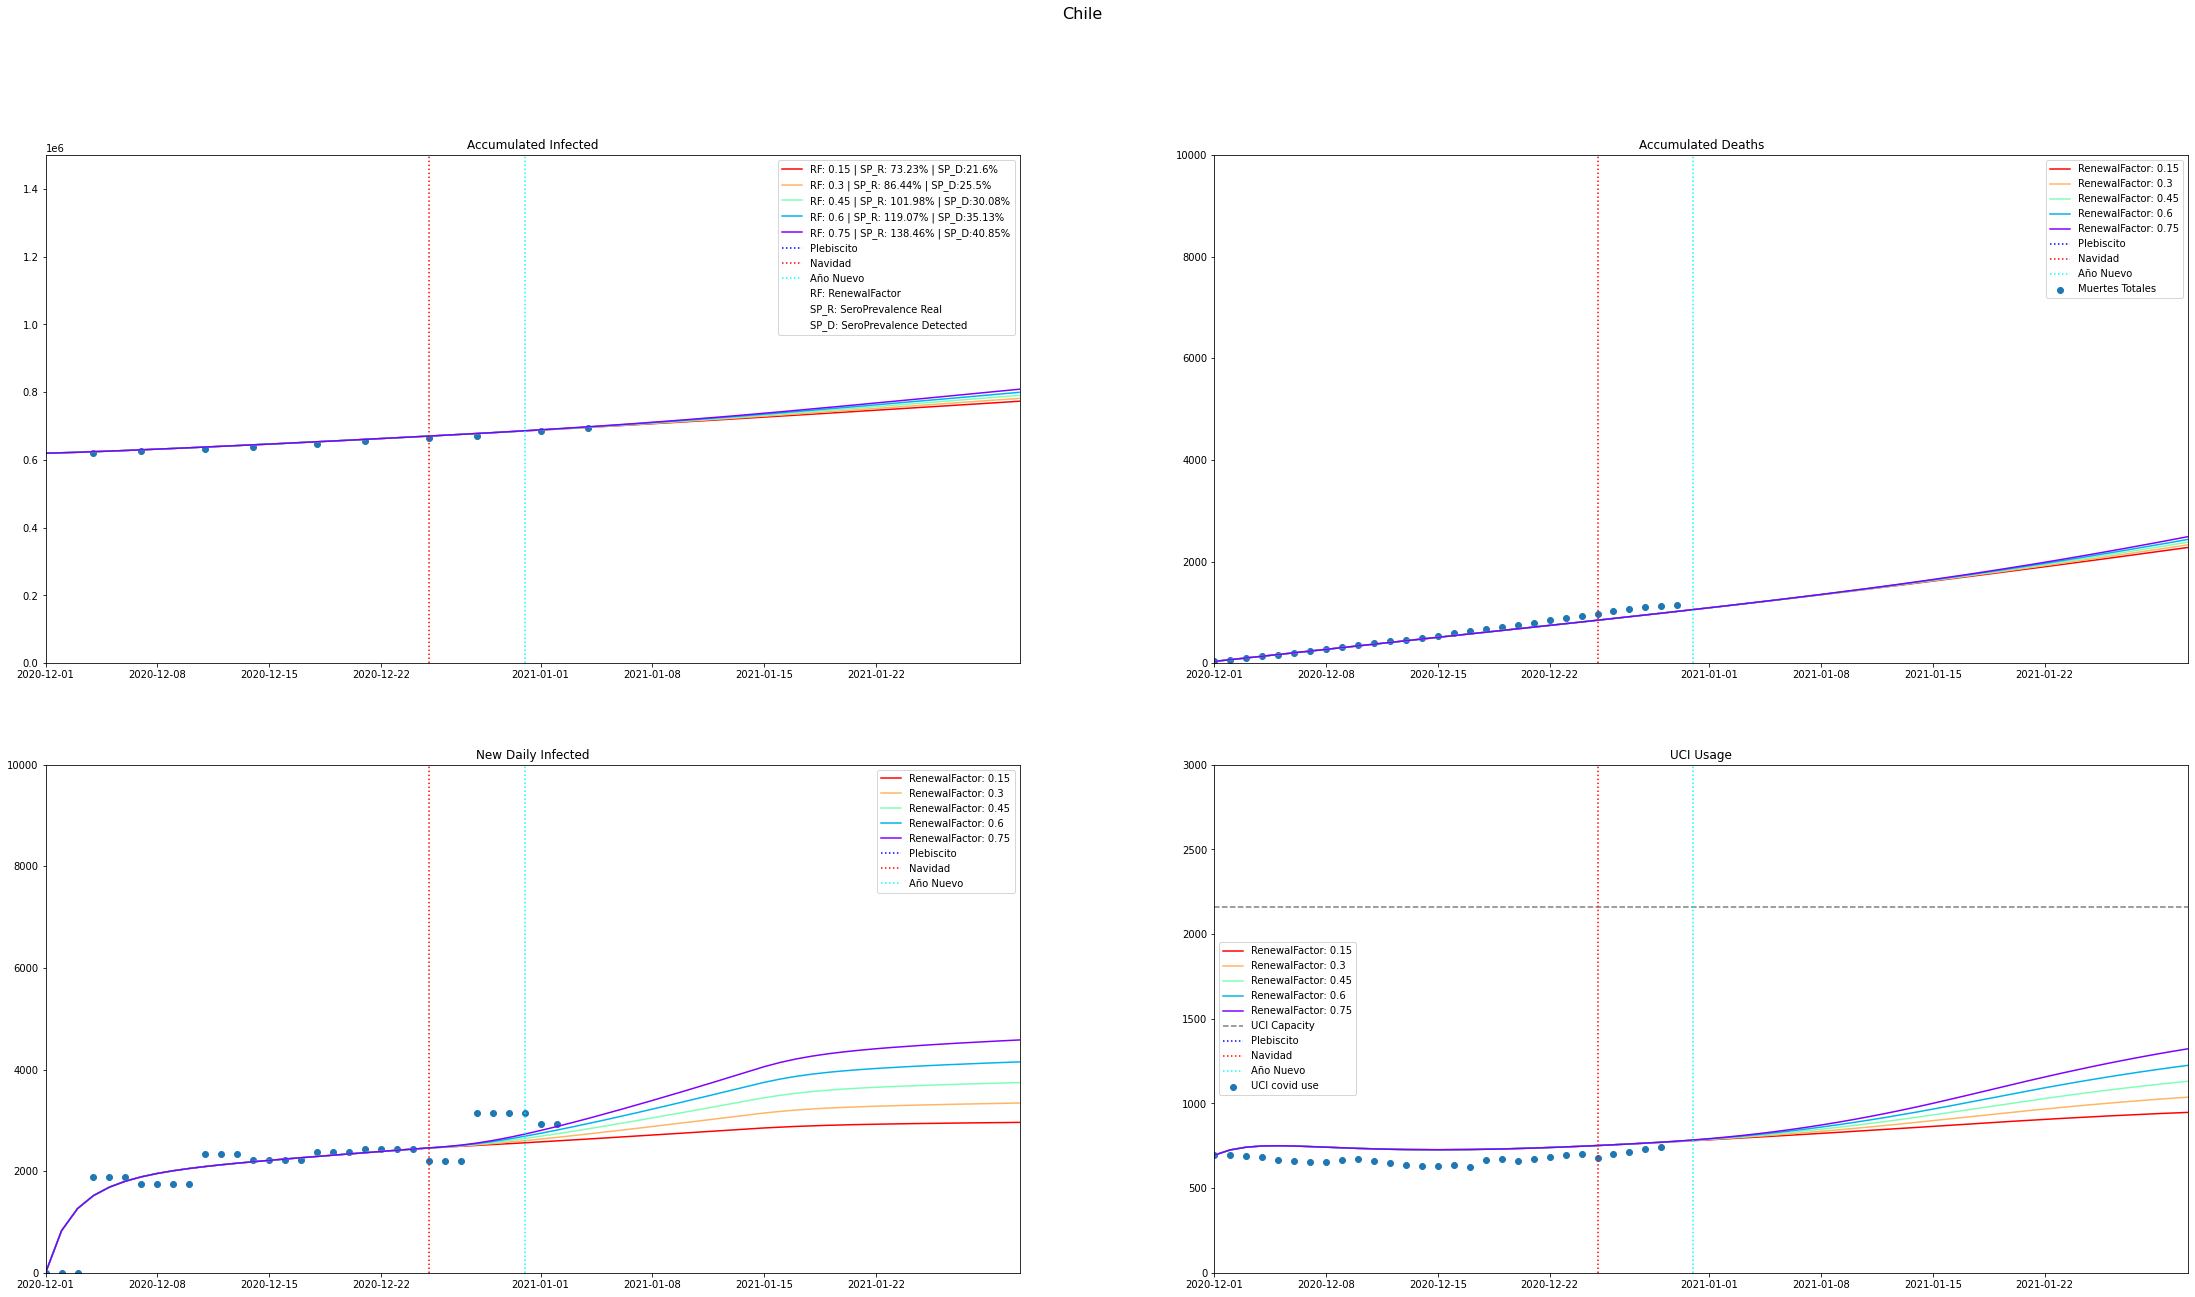

In [79]:
colors = plt.cm.rainbow_r(np.linspace(0,1,len(renewalFactor)))

fig, axs = plt.subplots(2, 2)

for i in range(len(simulation)):
    axs[0,0].plot(dates[i],simulation[i].I_ac_det,label='RF: '+str(renewalFactor[i])+' | SP_R: '+str(round(100*SeroPrevalence[i],2))+'%'+' | SP_D:'+str(round(100*SeroPrevalenceDet[i],2))+'%',color=colors[i])
    if sim_UK:
        axs[0,0].plot(dates[i],simulation_uk[i].I_ac_det,color=colors[i],linestyle='dashed')
axs[0,0].set_title('Accumulated Infected')
axs[0,0].set_xlim(initdate,enddate)
axs[0,0].set_ylim(0,1.5e6)


axs[0,0].scatter(state.I_ac_r_dates,state.I_ac_r)
#axs[0,0].axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
#axs[0,0].axvline(x = datetime(2020,8,22), linestyle = 'dotted',color = 'grey',label='Inicio Cuarentena')
#axs[0,0].axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
axs[0,0].axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
axs[0,0].axvline(x = datetime(2020,12,25), linestyle = 'dotted',color = 'red',label='Navidad')
axs[0,0].axvline(x = datetime(2020,12,31), linestyle = 'dotted',color = 'cyan',label='Año Nuevo')

#axs[0,0].plot([], [], ' ', label='SeroPrevalence: '+str(round(100*SeroPrevalence[i],2))+'%')
#axs[0,0].plot([], [], ' ', label='SeroPrevalence Detected: '+str(round(100*SeroPrevalenceDet[i],2))+'%')
#axs[0,0].axvline(x = datetime(2020,7,18), linestyle = 'dotted',color = 'grey',label='Cambio a fase 3')
#axs[0,0].axvline(x = datetime(2020,9,11), linestyle = 'dashed',color = 'grey',label='Cambio a fase 4')
#axs[0,0].axvline(x = datetime(2020,10,3), linestyle = 'dashdot',color = 'grey',label='Cambio a fase 2')
#
axs[0,0].plot([], [], ' ', label='RF: RenewalFactor')
axs[0,0].plot([], [], ' ', label='SP_R: SeroPrevalence Real')
axs[0,0].plot([], [], ' ', label='SP_D: SeroPrevalence Detected')
axs[0,0].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
axs[0,0].legend(loc=0)


for i in range(len(simulation)):
    axs[0,1].plot(dates[i],simulation[i].B,label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
    if sim_UK:
        axs[0,1].plot(dates[i],simulation_uk[i].B,color=colors[i],linestyle='dashed')
    
axs[0,1].set_title('Accumulated Deaths')
axs[0,1].set_xlim(initdate,enddate)
axs[0,1].set_ylim(0,1e4)

axs[0,1].scatter(state.Br_dates,state.Br,label='Muertes Totales')
#axs[0,1].scatter(state.hosp_dates,state.Br_hosp,label='Muertes Hospitalizados')
#axs[0,1].scatter(state.hosp_dates,state.Br_Nonhosp,label='Muertes No Hospitalizados')
#axs[0,1].scatter(state.hosp_dates,state.Br_Nonhosp,color = 'red',label='Muertes No Hospitalizados')
#axs[0,1].axvline(x = datetime(2020,8,22), linestyle = 'dotted',color = 'grey',label='Inicio Cuarentena')
#axs[0,1].axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
#axs[0,1].axvline(x = datetime(2020,7,18), linestyle = 'dotted',color = 'grey',label='Cambio a fase 3')
#axs[0,1].axvline(x = datetime(2020,9,11), linestyle = 'dashed',color = 'grey',label='Cambio a fase 4')
#axs[0,1].axvline(x = datetime(2020,10,3), linestyle = 'dashdot',color = 'grey',label='Cambio a fase 2')

#axs[0,1].axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
axs[0,1].axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
axs[0,1].axvline(x = datetime(2020,12,25), linestyle = 'dotted',color = 'red',label='Navidad')
axs[0,1].axvline(x = datetime(2020,12,31), linestyle = 'dotted',color = 'cyan',label='Año Nuevo')

axs[0,1].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
axs[0,1].legend(loc=0)



for i in range(len(simulation)):    
    axs[1,0].plot(dates[i],simulation[i].I_d_det,label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
    if sim_UK:
        axs[1,0].plot(dates[i],simulation_uk[i].I_d_det,color=colors[i],linestyle='dashed')    
axs[1,0].set_title('New Daily Infected')
axs[1,0].set_xlim(initdate,enddate)
axs[1,0].set_ylim(0,1e4)

axs[1,0].scatter(state.I_d_r_dates,state.I_d_r)

#axs[1,0].axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
#axs[1,0].axvline(x = datetime(2020,8,22), linestyle = 'dotted',color = 'grey',label='Inicio Cuarentena')
#axs[1,0].axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
axs[1,0].axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
axs[1,0].axvline(x = datetime(2020,12,25), linestyle = 'dotted',color = 'red',label='Navidad')
axs[1,0].axvline(x = datetime(2020,12,31), linestyle = 'dotted',color = 'cyan',label='Año Nuevo')

#axs[1,0].axvline(x = datetime(2020,7,18), linestyle = 'dotted',color = 'grey',label='Cambio a fase 3')
#axs[1,0].axvline(x = datetime(2020,9,11), linestyle = 'dashed',color = 'grey',label='Cambio a fase 4')
#axs[1,0].axvline(x = datetime(2020,10,3), linestyle = 'dashdot',color = 'grey',label='Cambio a fase 2')

axs[1,0].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
axs[1,0].legend(loc=0)


for i in range(len(simulation)):        
    axs[1,1].plot(dates[i],simulation[i].V,label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
    #axs[1,1].plot(dates[i],simulation[i].V_need,linestyle='dashed',color=colors[i])
    if sim_UK:
        axs[1,1].plot(dates[i],simulation_uk[i].V,color=colors[i],linestyle='dashed')    
axs[1,1].set_title('UCI Usage')
axs[1,1].set_xlim(initdate,enddate)
axs[1,1].set_ylim(0,3e3)

axs[1,1].scatter(state.UCI_dates,state.UCI_use_covid,label='UCI covid use')
#axs[1,1].plot(state.UCI_dates,state.UCI_capacity,label='UCI Capacity', linestyle = 'dashed', color = 'grey')
axs[1,1].plot(simulation[0].dates,simulation[0].V_cap,label='UCI Capacity', linestyle = 'dashed', color = 'grey')


#axs[1,1].axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
axs[1,1].axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
axs[1,1].axvline(x = datetime(2020,12,25), linestyle = 'dotted',color = 'red',label='Navidad')
axs[1,1].axvline(x = datetime(2020,12,31), linestyle = 'dotted',color = 'cyan',label='Año Nuevo')

#axs[1,1].axvline(x = datetime(2020,7,18), linestyle = 'dotted',color = 'grey',label='Cambio a fase 3')
#axs[1,1].axvline(x = datetime(2020,9,11), linestyle = 'dashed',color = 'grey',label='Cambio a fase 4')
#axs[1,1].axvline(x = datetime(2020,10,3), linestyle = 'dashdot',color = 'grey',label='Cambio a fase 2')

axs[1,1].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
axs[1,1].legend(loc=0)

fig.suptitle(state.name,fontsize=16)
fig.show()

In [82]:
%matplotlib tk
for i in range(len(simulation)):
    plt.plot(simulation[i].dates,simulation[i].I_det,label='RF: '+str(renewalFactor[i])+' | SP_R: '+str(round(100*SeroPrevalence[i],2))+'%'+' | SP_D:'+str(round(100*SeroPrevalenceDet[i],2))+'%',color=colors[i])
    plt.plot(simulation[i].dates,simulation[i].I_d_det,label='RF: '+str(renewalFactor[i])+' | SP_R: '+str(round(100*SeroPrevalence[i],2))+'%'+' | SP_D:'+str(round(100*SeroPrevalenceDet[i],2))+'%',color=colors[i])
plt.scatter(state.Ir_dates,state.Ir)
plt.legend(loc=0)
plt.show()

In [ ]:
state.Ir[0]

In [ ]:
type(simulation[0].I)

In [ ]:
SeroPrevalenceDet

In [ ]:
plt.plot(simulation)

# Lockdown data

In [ ]:
endpoint = '../Data/Confinamiento_COVID19.xlsx'
Data = pd.read_excel(endpoint,header=1,index_col=0)
valdivia = Data['14101'].iloc[2:]

In [ ]:
fig, ax = plt.subplots()
ax.plot(valdivia.astype(int))   
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d') 
fig.suptitle(state.name+' Lockdown',fontsize=16)
plt.show() 

# Cálculo de Peak 

In [ ]:
idx = [np.where(np.array(dates[i])>datetime(2020,9,1))[0][0] for i in range(len(renewalFactor))] 

## Daily Infected

In [ ]:
for i in range(len(simulation)):
    plt.plot(dates[i],simulation[i].I_d,label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
plt.axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
plt.axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
plt.axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
plt.title('Daily new infected')
plt.legend(loc=0)
plt.show()

In [ ]:
peakdates_Id = [dates[i][np.where(simulation[i].I_d==max(simulation[i].I_d[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peakdates_Id

In [ ]:
peak_I_d = [simulation[i].I_d[np.where(simulation[i].I_d==max(simulation[i].I_d[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_I_d

In [ ]:
peak_I_d_VMI = [simulation[i].V[np.where(simulation[i].I_d==max(simulation[i].I_d[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_I_d_VMI

In [ ]:
peak_I_d_D = [simulation[i].D[np.where(simulation[i].I_d==max(simulation[i].I_d[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_I_d_D

## VMI

In [ ]:
VMIneed = [[simulation[i].V_d[j] + simulation[i].Icr_D_d[j] for j in range(len(simulation[i].V))]  for i in range(len(renewalFactor))]

In [ ]:
for i in range(len(simulation)):
    plt.plot(dates[i],VMIneed[i],label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
plt.axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
plt.axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
plt.axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
plt.title('New VMI daily need')
plt.legend(loc=0)
plt.show()

In [ ]:
peakdates_VMI = [dates[i][np.where(simulation[i].V==max(simulation[i].V[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peakdates_VMI

In [ ]:
peak_VMI = [simulation[i].V[np.where(simulation[i].V==max(simulation[i].V[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_VMI 

In [ ]:
peak_VMI_I_d = [simulation[i].I_d[np.where(simulation[i].V==max(simulation[i].V[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_VMI_I_d 

In [ ]:
peakdates_VMI_d = [dates[i][np.where(VMIneed[i]==max(VMIneed[i][idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peakdates_VMI_d

In [ ]:
peak_VMI_D = [simulation[i].D[np.where(simulation[i].V==max(simulation[i].V[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_VMI_D 

In [ ]:
state.Dr_hosp

## Peak Deaths


In [ ]:
peak_D = [simulation[i].D[np.where(simulation[i].D==max(simulation[i].D[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]
peak_D_dates = [dates[i][np.where(simulation[i].D==max(simulation[i].D[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]
peak_D_VMI = [simulation[i].V[np.where(simulation[i].D==max(simulation[i].D[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]
peak_D_I_d = [simulation[i].I_d[np.where(simulation[i].D==max(simulation[i].D[idx[i]:]))[0][0]] for i in range(len(renewalFactor))]

In [ ]:
peak_D

In [ ]:
peak_D_dates

In [ ]:
peak_D_VMI

In [ ]:
peak_D_I_d


In [ ]:
for i in range(len(simulation)):
    plt.plot(dates[i],simulation[i].D,label='RenewalFactor: '+str(renewalFactor[i]),color=colors[i])
plt.axvline(x = SPchange_date, linestyle = 'dotted',color = 'grey',label='Inicio Apertura')
plt.axvline(x = fiestaspatrias, linestyle = 'dotted',color = 'red',label='18 Sept')
plt.axvline(x = plebiscito, linestyle = 'dotted',color = 'blue',label='Plebiscito')
plt.title('Daily Deaths')
plt.legend(loc=0)
plt.show()

## Single plots

### SEIRD

In [ ]:
plt.plot(simulation1.t,simulation1.S,label='S')
plt.plot(simulation1.t,simulation1.E,label='E')
plt.plot(simulation1.t,simulation1.I,label='I')
plt.plot(simulation1.t,simulation1.R,label='R')
plt.plot(simulation1.t,simulation1.B,label='B')
plt.axvline(x = t_end, linestyle = 'dotted',color = 'grey')
plt.title('SEIRD')
plt.legend(loc=0)
plt.show()

### Daily Deaths

In [ ]:
plt.plot(simulation1.t,simulation1.D,label='sim1')
plt.title('Deaths')
plt.show()

### VMI Usage

In [ ]:
plt.plot(simulation1.t,simulation1.V_cap,label='VMI capacity sim1')
plt.plot(simulation1.t,simulation1.V,label='VMI sim1')
plt.legend(loc=0)
plt.title('VMI')
plt.scatter(state.sochimi_tr,state.Vr,label='Real Data')
plt.scatter(state.sochimi_tr,state.Vr_tot,label='Real Data')
plt.show()

### Hospitalization

In [ ]:
plt.plot(simulation1.t,simulation1.H_cap,label='sim1')
plt.plot(simulation1.t,simulation1.Hse+simulation1.Hout,label='UCI/UTI Beds')
plt.legend(loc=0)
plt.title('Hospitalization')

plt.scatter(state.sochimi_tr,state.Hr,label='Real Data')
plt.scatter(state.sochimi_tr,state.Hr_tot,label='Real Data')
plt.show()

### Deaths by cause

In [ ]:
plt.plot(simulation1.t,simulation1.D,label='sim1')
plt.plot(simulation1.t,simulation1.V_D_d,label='V_D sim1')
plt.plot(simulation1.t,simulation1.Hse_D_d,label='Hse_D sim1')
plt.plot(simulation1.t,simulation1.Icr_D_d,label='Icr_D sim1')
plt.plot(simulation1.t,simulation1.Ise_D_d,label='Ise_D sim1')

plt.legend(loc=0)
plt.title('Deaths by cause')
plt.show()

### Hospital saturation

In [ ]:
plt.plot(simulation1.t,simulation1.H_sat,label='HSat')
plt.plot(simulation1.t,simulation1.V_sat,label='Vsat')
plt.legend(loc=0)
plt.title('Saturation')
plt.show()

## Peak Date

In [ ]:
peakidx = np.where(state.Ir==max(state.Ir))[0][0]
datapeakdate = state.sochimi_dates[peakidx]

In [ ]:
datapeakdate

In [ ]:
simulation.peak_date

In [ ]:
datapeakdate

In [ ]:
Peak_delta = (simulation.peak_date -datapeakdate).days

In [ ]:
Peak_delta